# Molecular Dynamics Simulations

## Overview

### Questions

* What is molecular dynamics?
* How do I set up a molecular dynamics simulation in HOOMD-blue?

### Objectives

* Describe the **equations of motion** of the system and HOOMD solves them with **time steps**.
* Define **forces**, **potential energy** and explain how HOOMD evaluates **pair potentials** within a cutoff.
* Explain how the MD **Integrator** and **integration methods** solve the equations of motion and allow for different **thermodynamic ensembles**.

## Boilerplate code

In [1]:
import hoomd
import numpy
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

## Equations of motion

**Molecular dynamics** simulations model the movement of particles over time by solving the **equations of motion** numerically, advancing the state of the system forward by time `dt` on each time step.
You can use **molecular dynamics** to model dynamic, time dependent processes (like fluid flow) or thermodynamic equilibrium states (like crystals).
This tutorial models a system of Lennard-Jones particles crystallizing.

The **Integrator** class in the **md** package implements molecular dynamics integration in HOOMD-blue:

In [2]:
integrator = hoomd.md.Integrator(dt=0.005)

The `dt` property sets the step size:

In [3]:
integrator.dt

0.005

## Forces

The force term in the equations of motion determines how particles interact.The `forces` **Integrator** property is the list of forces applied to the system. The default is no forces:

In [4]:
integrator.forces[:]

[]

You can add any number of **force** objects to this list. Each such object computes forces on all particles in the system state.
**Integrator** will add all of the forces together into the net force used in the **equations of motion**.

Many forces that HOOMD provides are derived from the **potential energy.** **Pair potentials** define the functional form of the energy between a single pair of particles given their separation distance *r*.
The Lennard-Jones potential is: $$V_{\mathrm{LJ}}(r) = 4 \varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]$$

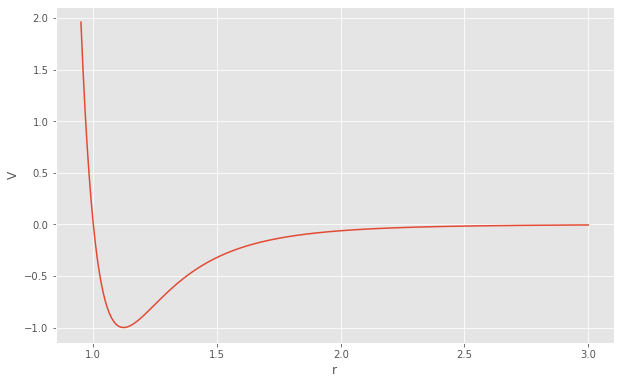

In [5]:
sigma = 1
epsilon = 1
r = numpy.linspace(0.95, 3, 500)
V_lj = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(r, V_lj)
ax.set_xlabel('r')
ax.set_ylabel('V')
fig

Evaluating **pair potentials** over all pairs in the system is very computationally expensive.
**Molecular dynamics** simulations cut off potentials to 0 for all $r > r_{\mathrm{cut}}$ to make the computation fast through the use of a **neighbor list**.
By default, HOOMD cuts off pair potentials at $r_{\mathrm{cut}}$ though there are options to shift or smooth the potential at the cutoff.

HOOMD provides several neighbor list options to choose from.
**Cell** performs well in most situations:

In [6]:
cell = hoomd.md.nlist.Cell()

Construct the **LJ** pair force object:

In [7]:
lj = hoomd.md.pair.LJ(nlist=cell)

Pair potentials accept parameters for every pair of particle types in the simulation.
Define a single A-A interaction for this tutorial:

In [8]:
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5

Add the force to the **Integrator**:

In [9]:
integrator.forces.append(lj)

## Integration methods

HOOMD-blue provides a number of **integration methods**, which define the **equations of motion** to use for a subset of the particles in the system.
These methods are named after the **thermodynamic ensemble** they implement.
For example, **NVE** implements Newton's laws while **NVT** adds a thermostat degree of freedom to the system's Hamiltonian that causes the system to sample the canonical ensemble.
This tutorial demonstrates the crystallization of Lennard-Jones particles, so apply the **NVT** method all particles:

In [10]:
nvt = hoomd.md.methods.NVT(kT=1.5, filter=hoomd.filter.All(), tau=1.0)

`kT` is the set temperature multiplied by Boltzmann's constant and has units of energy and `tau` is a time constant that controls the amount of coupling between the thermostat and particle's degrees of freedom.
`filter` is a particle filter object that defines which particles this **integration method** applies to.
You can use it to apply multiple integration methods to different sets of particles or leave some particles fixed.

Add the method to the **Integrator**:

In [11]:
integrator.methods.append(nvt)

The remaining sections in this tutorial will show you how to initialize a random low density state, compress the system to a target density, and run the simulation long enough to self-assemble an ordered state.

[Next section](02-Initializing-a-Random-System.ipynb).